In [1]:
import os, sys
sys.path.insert(1, '../')
from time import time
from importlib import reload

import numpy as np
import scipy as sc
import pandas as pd

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import utils
import concentration as conc

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [2]:
native_df = pd.read_csv('Native_allchunks_test_tpu_model.csv', index_col=0)
native_df

,sequence,measured,predicted
index,,,
0,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAAAAACTAGCA...,11.825806,11.353749
1,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAATTTAAAGAATTTC...,11.412778,9.643128
2,TGCATTTTTTTCACATCAAAAAAAAGGACGTTCCACACTTGGCTGC...,10.623805,11.864820
3,TGCATTTTTTTCACATCAAAATCCGTGTAATACCAAGTCATCCTCA...,7.703389,8.650239
4,TGCATTTTTTTCACATCAGAAAAAAAGTATAATGTCAGATTTTTGT...,11.397473,13.881278
...,...,...,...
61145,TGCATTTTTTTCACATCAGAAAAAAAAAAAAAAAAAAAAAAAGAAA...,14.220082,12.520042
61146,TGCATTTTTTTCACATCAGAAAAAAAAAAAAGAGGAGACTTGAAGA...,6.978840,7.298204
61147,TGCATTTTTTTCACATCAGAAAAAAAAAAGGGATTGGGCGGTAATG...,3.917299,8.096985


In [ ]:
reload(utils)
n_trial = 300
qs = np.array([0.5, 0.25, 0.75])
ns = np.logspace(np.log10(50), np.log10(1000), num=10, base=10).astype(int)
alpha = 0.1
delta = 0.08
theta_grid = np.arange(0, 20, 0.1)
parallelize = False
use_hoeffding = True
c = 0.9

y_all = native_df.measured.to_numpy()
f_all = native_df.predicted.to_numpy()
f_all = 20 * (f_all - np.min(f_all)) / (np.max(f_all) - np.min(f_all))

columns = ['q', 'n', 'width', 'covered', 'estimator']
results = []
for q_idx, q in enumerate(qs):
    for n_idx, n in enumerate(ns):
        for i in tqdm(range(n_trial)):
            width_cl, width_pp, cov_cl, cov_pp  = utils.trial(
                y_all, f_all, q, n, alpha, delta, theta_grid, parallelize, c=c, use_hoeffding=use_hoeffding)
            results.append([q, n, width_cl, int(cov_cl), 'classical'])
            results.append([q, n, width_pp, int(cov_pp), 'prediction-powered'])
            
        df = pd.DataFrame(results, columns=columns)
        df.to_csv('native-120722-delta{}-c{}.csv'.format(delta, c))
        print('n = {}, q = {}'.format(n, q))
        print('  avg. classical width: {:.2f}, avg. PP width: {:.2f}'.format(
            df.loc[(df.estimator == 'classical') & (df.n == n) & (df.q == q)].width.mean(),
            df.loc[(df.estimator == 'prediction-powered') & (df.n == n) & (df.q == q)].width.mean()
        ))
        print('  avg. classical cov: {:.2f}, avg. PP cov: {:.2f}'.format(
            df.loc[(df.estimator == 'classical') & (df.n == n) & (df.q == q)].covered.mean(),
            df.loc[(df.estimator == 'prediction-powered') & (df.n == n) & (df.q == q)].covered.mean()
        ))

 12%|█▏        | 35/300 [02:20<17:53,  4.05s/it]

/home/clarafy/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


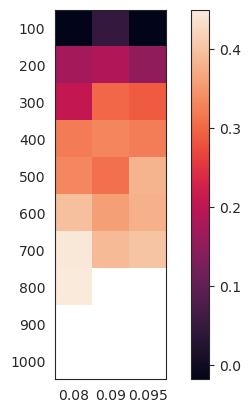

In [14]:
plt.imshow(np.mean((w_nxdxtx2[:, :, :, 0] - w_nxdxtx2[:, :, :, 1]) / 1, axis=2))
plt.xticks(range(deltas.size), deltas)
plt.yticks(range(ns.size), ns)

plt.colorbar();
plt.show() 

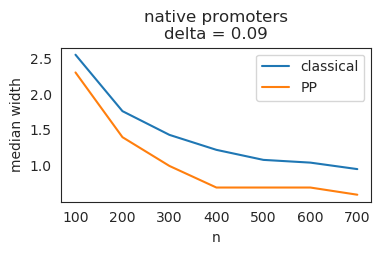

In [27]:
d_idx = 1
n_max = 7

wcl_n = np.median(w_nxdxtx2[:, d_idx, :, 0], axis=1)
wpp_n = np.median(w_nxdxtx2[:, d_idx, :, 1], axis=1)

plt.figure(figsize=(4, 2))
plt.plot(ns[: n_max], wcl_n[: n_max], label='classical')
plt.plot(ns[: n_max], wpp_n[: n_max], label='PP')
plt.xlabel('n');
plt.ylabel('median width')
plt.legend();
plt.title('native promoters\ndelta = {}'.format(deltas[d_idx]))
plt.show()